# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [ ]:
from sklearn.decomposition import PCA
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 2
fuzzification_kernel_size = 16
enrich_lemmas_with_wn = False
full_eval = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
if not full_eval:
    sample_size = 100
    X_train, y_train, X_test, y_test = (
        X_train[:sample_size],
        y_train[:sample_size],
        # X_train[:sample_size],
        # y_train[:sample_size],
        X_test[:sample_size],
        y_test[:sample_size]
    )
# evaluating space on full, combined training+test set, as fuzzification model is nonparametric
X_test = pd.concat([X_train, X_test])
y_test = pd.concat([y_train, y_test])

sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel(
    dim_reduc=PCA(n_components=n_components)
)
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.23934661,  0.06020244],
       [ 0.05484644,  0.02753255],
       [ 0.19791432, -0.00143419],
       [-0.27410486, -0.00122942],
       [-0.0165537 , -0.03706417],
       [ 0.22645542, -0.04045445],
       [ 0.19826768, -0.21729906],
       [ 0.12638323, -0.09779878],
       [ 0.27127096, -0.00173299],
       [-0.2852646 ,  0.13212955],
       [ 0.18903142, -0.16688903],
       [ 0.05590243,  0.16873482],
       [-0.24353845, -0.15435177],
       [-0.2908657 ,  0.15334104],
       [-0.09289529, -0.02173546],
       [ 0.1911663 ,  0.0490924 ],
       [ 0.13713275,  0.1183939 ],
       [ 0.12549448,  0.19480404],
       [ 0.23699291, -0.05885468],
       [-0.17465271,  0.32018986],
       [-0.2056076 ,  0.04843473],
       [-0.20785132, -0.04329443],
       [-0.1272805 ,  0.08763182],
       [-0.31160662,  0.29396275],
       [-0.28095376,  0.08417758],
       [-0.1768581 ,  0.10006992],
       [ 0.21107925, -0.09158009],
       [ 0.27538392, -0.03983474],
       [ 0.171828  ,

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate models

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for baseline_sent approac

,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_mean_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_baseline_sent_wasserstein-1_sim,...,fuzzy_baseline_tok_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_mean_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,0.023786,0.064437,0.234020,0.147786,0.234020,-0.028125,-0.091447,-0.091447,-0.068975,0.128819,...,0.006179,6.051562e-09,-0.084059,6.051562e-09,-0.004760,0.000072,0.000072,0.000062,0.232746,0.025801
1,0.000084,0.054730,-0.006779,-0.009893,-0.006779,0.038152,0.051639,0.051639,0.014530,0.111983,...,0.007169,6.061234e-09,0.086824,6.061234e-09,-0.001960,0.000066,0.000066,0.000061,-0.398656,0.022727
2,0.021913,-0.056394,0.038970,0.163031,0.038970,0.002431,-0.017290,-0.017290,-0.022736,0.119865,...,0.000622,-3.982063e-06,-0.042681,-3.982063e-06,-0.001091,0.000073,0.000073,-0.000086,0.121188,-0.012349
3,-0.054763,-0.200125,0.001922,-0.000018,0.001922,0.015325,0.008839,0.008839,0.004075,-0.262770,...,-0.072994,6.122937e-09,0.086824,6.122937e-09,0.002643,0.000068,0.000068,0.000064,-0.577791,0.022415
4,0.013081,0.033142,-0.457064,-0.455706,-0.457064,0.008181,-0.122633,-0.122633,-0.077496,0.212129,...,0.008110,6.121835e-09,-0.133796,6.121835e-09,0.002571,-0.017559,-0.017559,-0.992093,0.212079,-0.031303


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

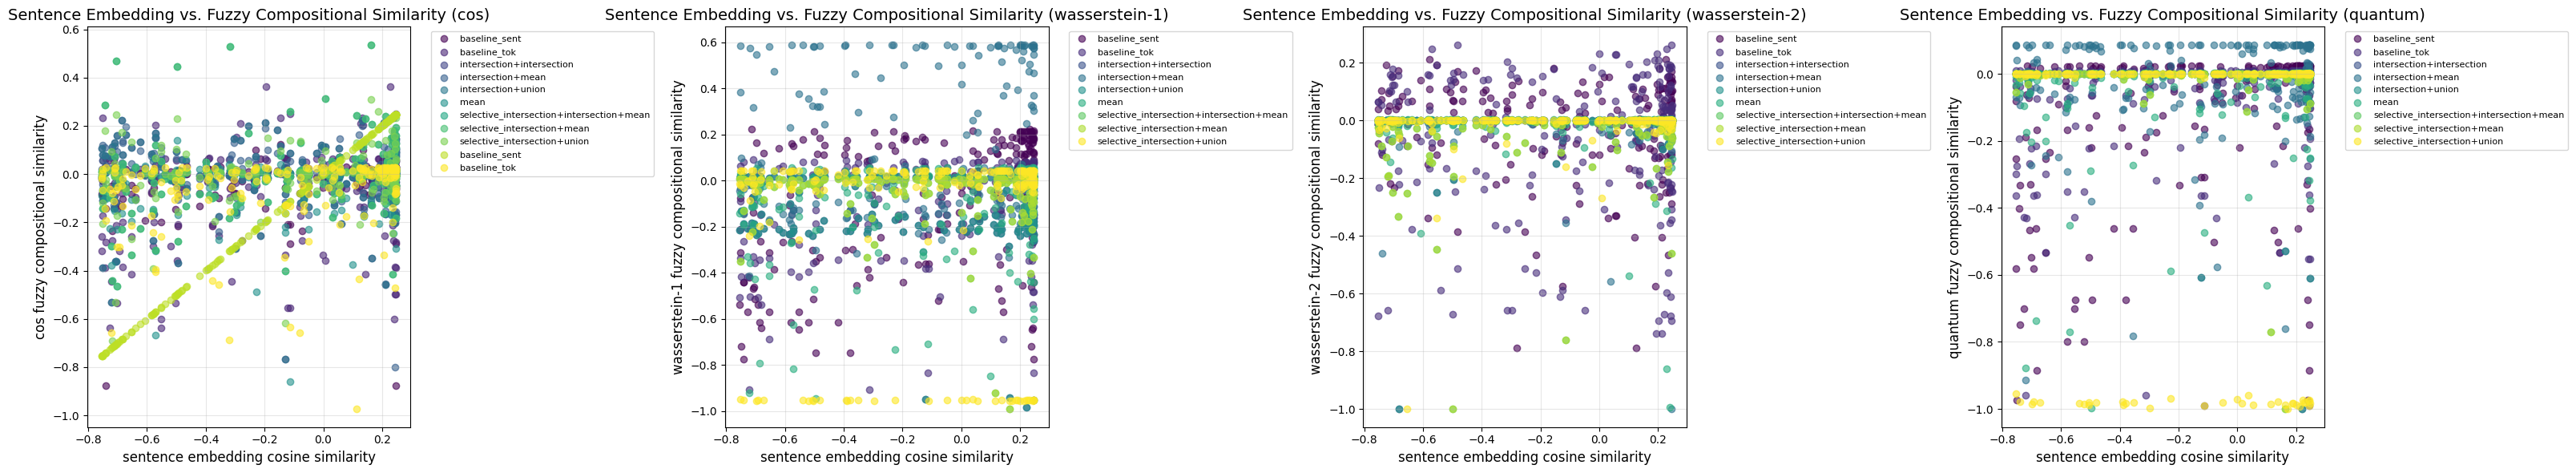

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

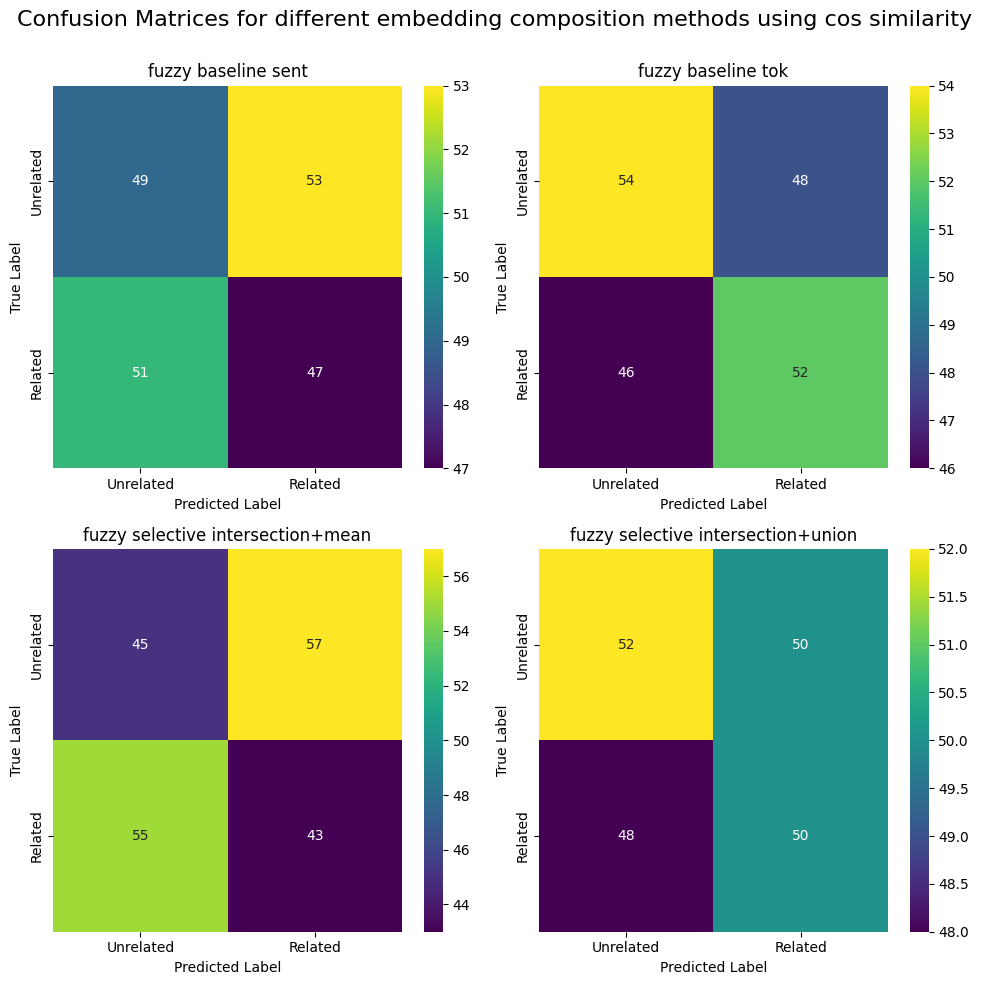

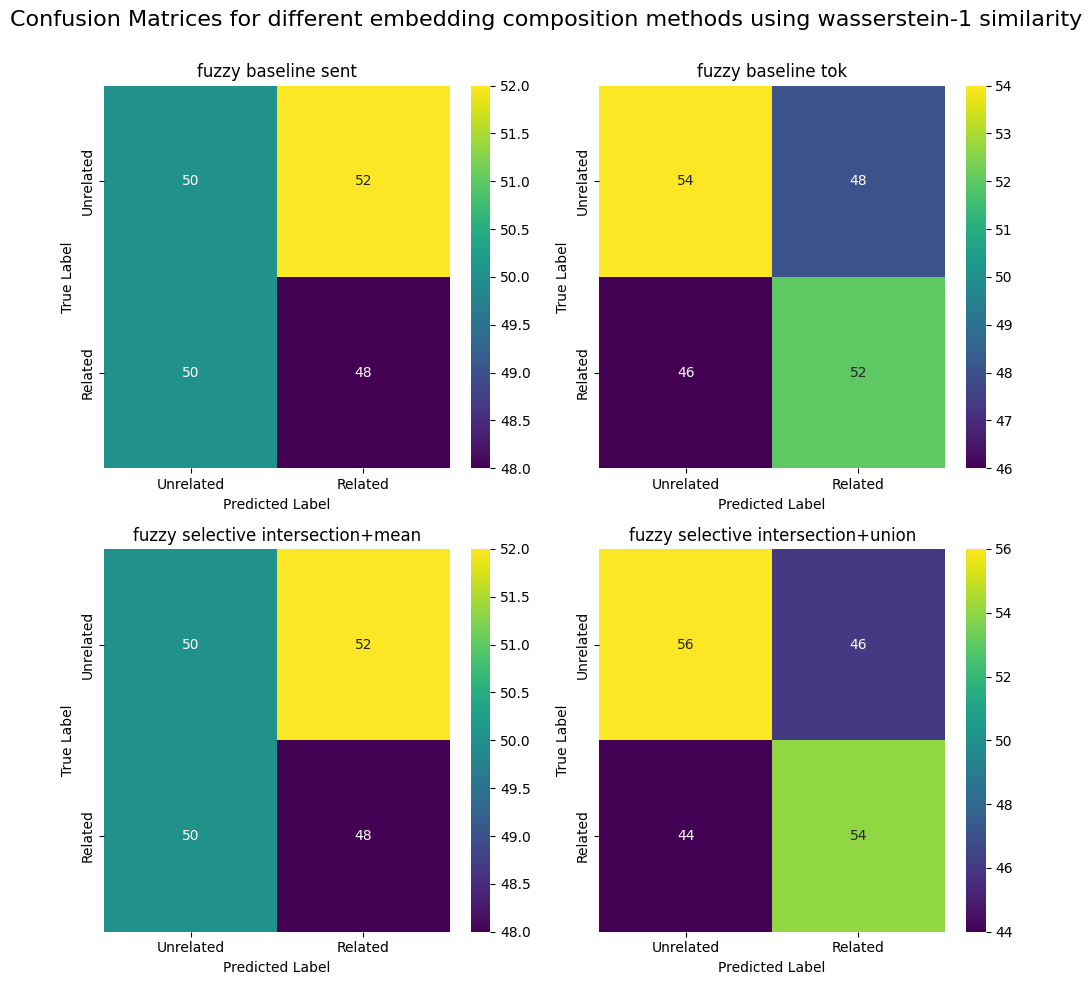

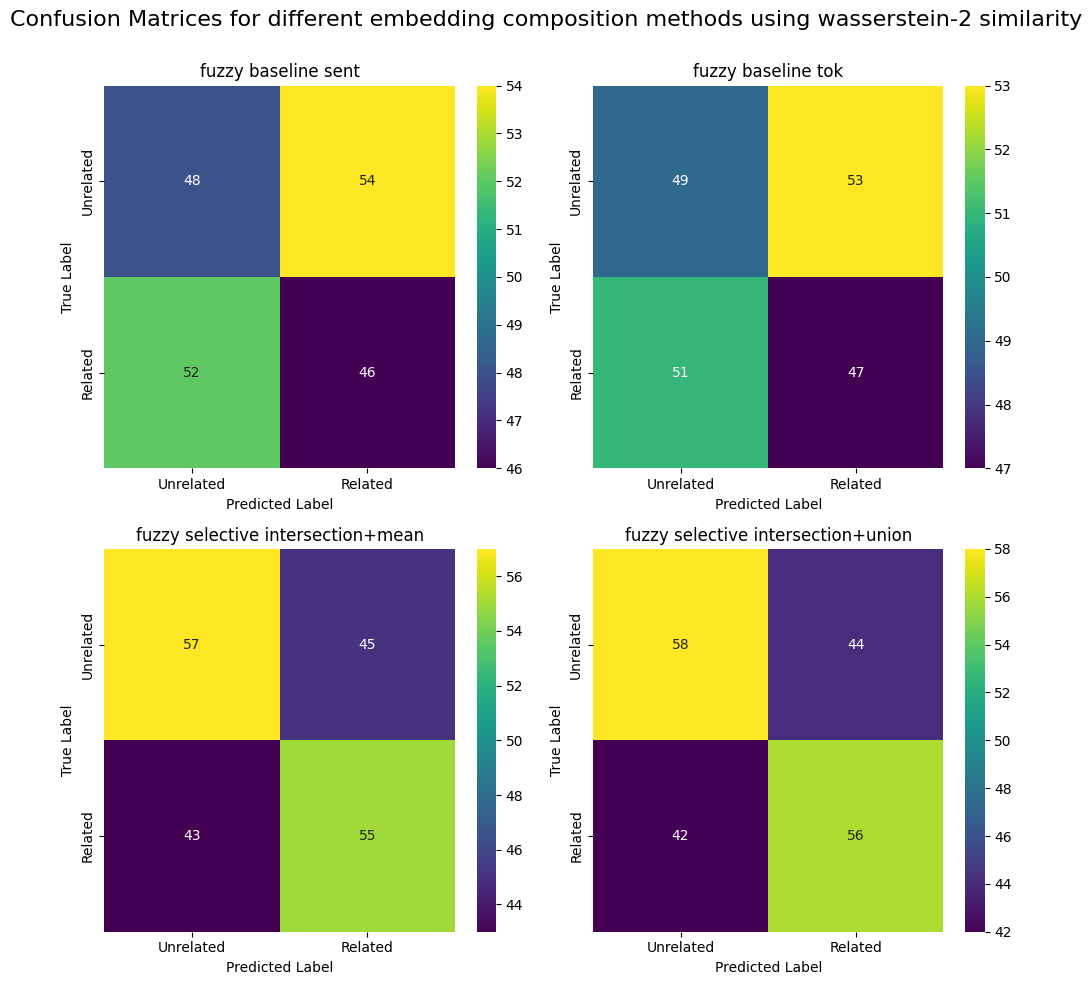

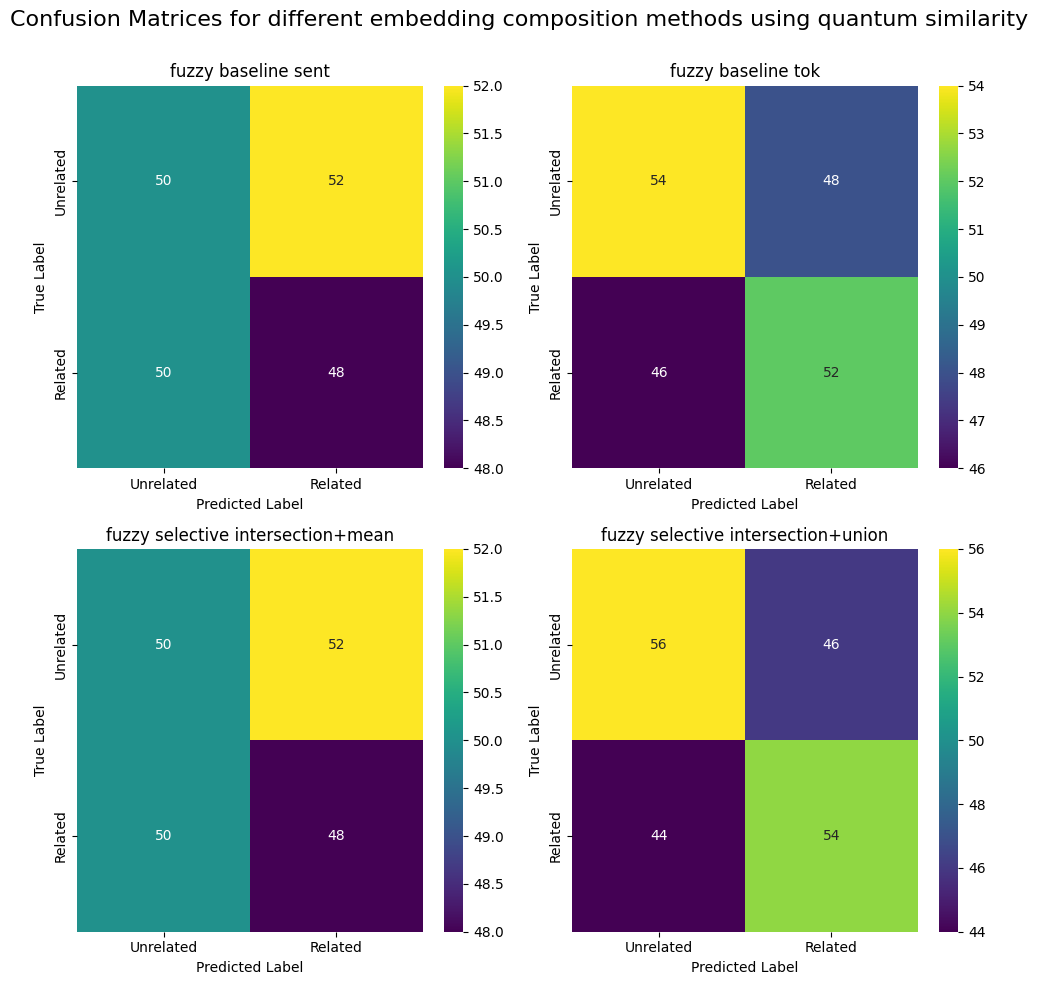

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test
)

# Evaluation Results

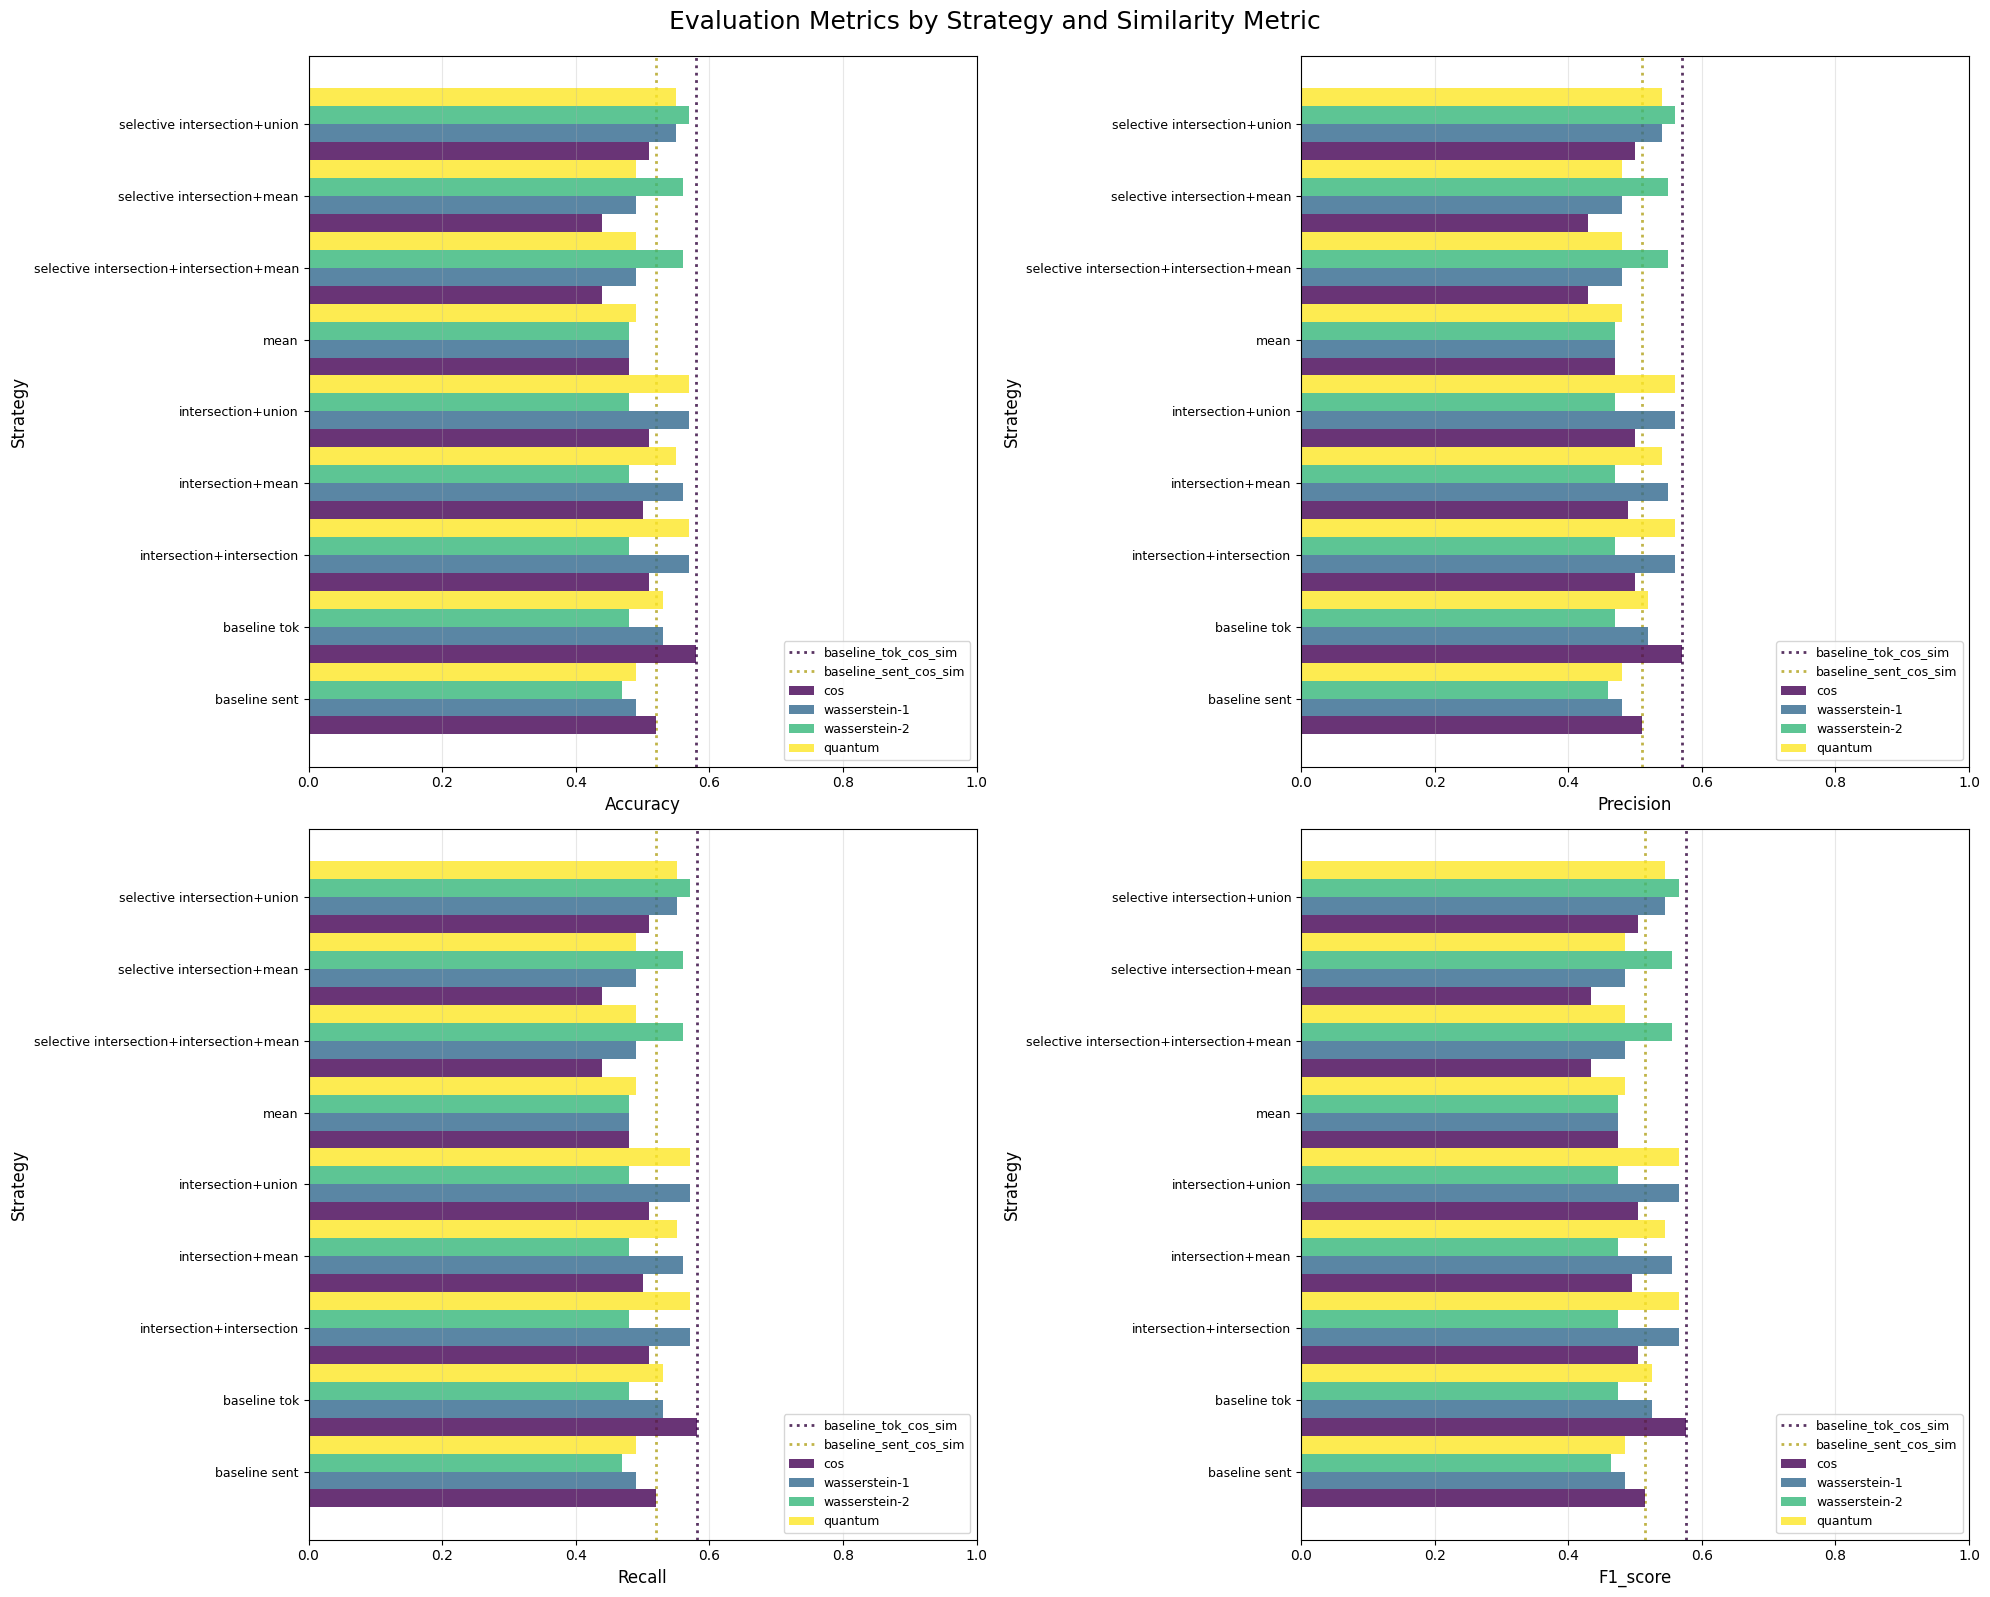

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,baseline_tok,cos,baseline_tok_cos_sim,0.58,0.57,0.581633,0.575758
1,intersection+intersection,quantum,fuzzy_intersection+intersection_quantum_sim,0.57,0.56,0.571429,0.565657
2,intersection+union,quantum,fuzzy_intersection+union_quantum_sim,0.57,0.56,0.571429,0.565657
3,intersection+intersection,wasserstein-1,fuzzy_intersection+intersection_wasserstein-1_sim,0.57,0.56,0.571429,0.565657
4,intersection+union,wasserstein-1,fuzzy_intersection+union_wasserstein-1_sim,0.57,0.56,0.571429,0.565657
5,selective_intersection+union,wasserstein-2,fuzzy_selective_intersection+union_wasserstein...,0.57,0.56,0.571429,0.565657
6,intersection+mean,wasserstein-1,fuzzy_intersection+mean_wasserstein-1_sim,0.56,0.55,0.561224,0.555556
7,selective_intersection+intersection+mean,wasserstein-2,fuzzy_selective_intersection+intersection+mean...,0.56,0.55,0.561224,0.555556
8,selective_intersection+mean,wasserstein-2,fuzzy_selective_intersection+mean_wasserstein-...,0.56,0.55,0.561224,0.555556
9,intersection+mean,quantum,fuzzy_intersection+mean_quantum_sim,0.55,0.54,0.551020,0.545455


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_test)
metrics_df[:10]

In [ ]:
metrics_df.to_csv(f"full_eval={full_eval},wn_enriched={enrich_lemmas_with_wn},n_components={n_components},kernel_size={fuzzification_kernel_size}.tsv", sep="\t")